In [2]:
import os

import dgl
import torch
import torch_geometric as tg

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn

from graphlime import GraphLIME
from mumin import MuminDataset

import torchmetrics as tm

from tqdm.notebook import tqdm
from collections import defaultdict

from torch_geometric.data import Data as tgData

from transformers import AutoModel, AutoTokenizer

from mumin_explainable.architectures.graphs import GAT
from mumin_explainable.processor.tweetnormalizer import normalizeTweet

from dotenv import load_dotenv

%matplotlib inline

# Setup mumin graph

In [2]:
size= 'small'

dataset_mumin = MuminDataset(
    twitter_bearer_token=os.getenv('TWITTER_BEARER_TOKEN'),
    size=size,
    dataset_path=f'./data/datasets/mumin-{size}.zip'
)
dataset_mumin.compile()
mumin_graph = dataset_mumin.to_dgl()
mumin_graph

2022-08-30 09:16:40,702 [INFO] Loading dataset
2022-08-30 09:18:54,941 [INFO] Outputting to DGL


Graph(num_nodes={'article': 1446, 'claim': 2083, 'hashtag': 27802, 'image': 1015, 'reply': 177816, 'tweet': 4061, 'user': 152038},
      num_edges={('article', 'has_article_inv', 'tweet'): 1890, ('claim', 'discusses_inv', 'tweet'): 4749, ('hashtag', 'has_hashtag_inv', 'tweet'): 2284, ('hashtag', 'has_hashtag_inv', 'user'): 49626, ('image', 'has_image_inv', 'tweet'): 1019, ('reply', 'posted_inv', 'user'): 177816, ('reply', 'quote_of', 'tweet'): 88495, ('reply', 'reply_to', 'tweet'): 78576, ('tweet', 'discusses', 'claim'): 4749, ('tweet', 'has_article', 'article'): 1890, ('tweet', 'has_hashtag', 'hashtag'): 2284, ('tweet', 'has_image', 'image'): 1019, ('tweet', 'mentions', 'user'): 1112, ('tweet', 'posted_inv', 'user'): 4061, ('tweet', 'quote_of_inv', 'reply'): 88495, ('tweet', 'reply_to_inv', 'reply'): 78576, ('tweet', 'retweeted_inv', 'user'): 12800, ('user', 'follows', 'user'): 17974, ('user', 'follows_inv', 'user'): 17974, ('user', 'has_hashtag', 'hashtag'): 49626, ('user', 'mentions

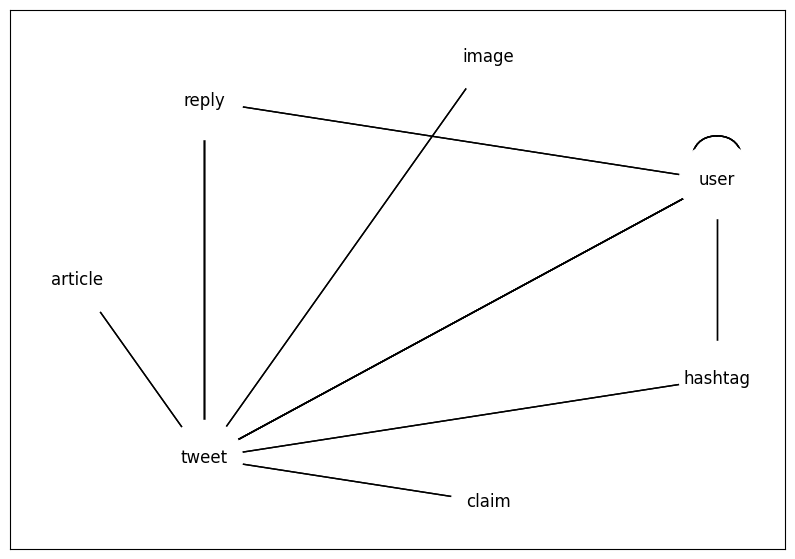

In [3]:
plt.figure(figsize=(10, 7))
metagraph = mumin_graph.metagraph()
nx.draw_networkx(metagraph, 
                 pos=nx.shell_layout(metagraph), 
                 node_color='white', 
                 node_size=3000,
                 arrows=False)

# Setup subgraph

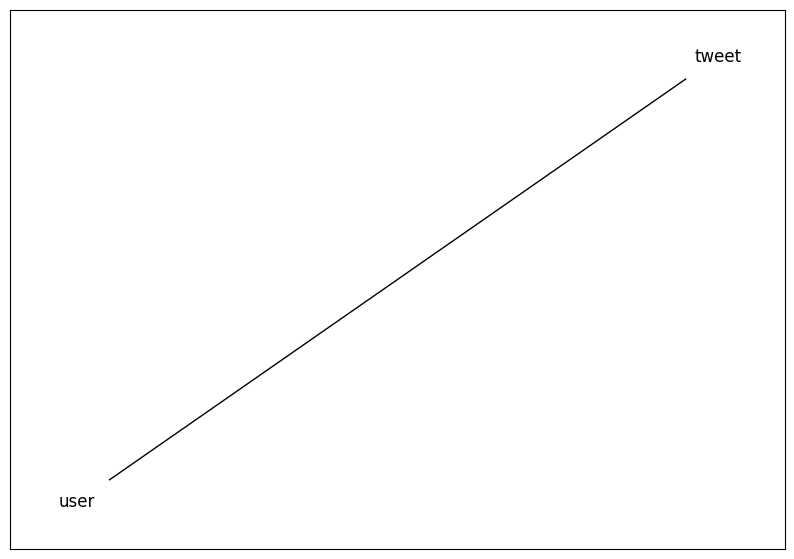

In [4]:
rel = ('user', 'posted', 'tweet')
posted_subgraph = dgl.edge_type_subgraph(mumin_graph, etypes=[rel])
train_mask = posted_subgraph.nodes['tweet'].data['train_mask']
val_mask = posted_subgraph.nodes['tweet'].data['val_mask']
test_mask = posted_subgraph.nodes['tweet'].data['test_mask']

plt.figure(figsize=(10, 7))
posted_metagraph = posted_subgraph.metagraph()
nx.draw_networkx(posted_metagraph, 
                 pos=nx.shell_layout(posted_metagraph), 
                 node_color='white', 
                 node_size=3000,
                 arrows=False)

# Setup dataset

In [5]:
edges_index = torch.cat([
    posted_subgraph.edges(etype='posted')[0].unsqueeze(0),
    posted_subgraph.edges(etype='posted')[1].unsqueeze(0)
], dim=0)
data = tgData(
    x=posted_subgraph.nodes['tweet'].data['feat'],
    y=posted_subgraph.nodes['tweet'].data['label'],
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
    edge_index=edges_index.long())

tweet_df = dataset_mumin.nodes['tweet']
reply_df = dataset_mumin.nodes['reply']
quote_of_df = dataset_mumin.rels[('reply', 'quote_of', 'tweet')]
reply_quote_tweet_df = (reply_df.merge(quote_of_df, left_index=True, right_on='src')
                          .merge(tweet_df, left_on='tgt', right_index=True)
                          .reset_index(drop=True))

# Train GAT

In [6]:
hparams = {
    'input_dim': data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(data.y).item() + 1
}

model = GAT(**hparams).double()

lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

accuracy = tm.Accuracy()
precision_recall = tm.functional.precision_recall

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(data.x, data.edge_index)
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        acc = accuracy(output[data.train_mask], data.y[data.train_mask])
        pr = precision_recall(output[data.train_mask], data.y[data.train_mask])
        print('Epoch: {:3d}, acc = {:.3f}, pr = {}'.format(epoch, acc, pr))

model.eval()

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0, acc = 0.730, pr = (tensor(0.7304), tensor(0.7304))
Epoch:  10, acc = 0.809, pr = (tensor(0.8085), tensor(0.8085))
Epoch:  20, acc = 0.814, pr = (tensor(0.8138), tensor(0.8138))
Epoch:  30, acc = 0.860, pr = (tensor(0.8603), tensor(0.8603))
Epoch:  40, acc = 0.867, pr = (tensor(0.8668), tensor(0.8668))
Epoch:  50, acc = 0.853, pr = (tensor(0.8530), tensor(0.8530))
Epoch:  60, acc = 0.873, pr = (tensor(0.8731), tensor(0.8731))
Epoch:  70, acc = 0.867, pr = (tensor(0.8665), tensor(0.8665))
Epoch:  80, acc = 0.864, pr = (tensor(0.8635), tensor(0.8635))
Epoch:  90, acc = 0.870, pr = (tensor(0.8698), tensor(0.8698))
Epoch: 100, acc = 0.869, pr = (tensor(0.8691), tensor(0.8691))
Epoch: 110, acc = 0.867, pr = (tensor(0.8668), tensor(0.8668))
Epoch: 120, acc = 0.870, pr = (tensor(0.8701), tensor(0.8701))
Epoch: 130, acc = 0.872, pr = (tensor(0.8721), tensor(0.8721))
Epoch: 140, acc = 0.845, pr = (tensor(0.8448), tensor(0.8448))
Epoch: 150, acc = 0.866, pr = (tensor(0.8659), tensor(0

GAT(
  (conv1): GATConv(3, 2, heads=8)
  (conv2): GATConv(16, 2, heads=1)
)

In [ ]:
def get_all_nodes_explanation(model, explainer, data, dataset_mumin):

    feature_id_map = {
        'num_retweets': 0,
        'num_replies': 1,
        'num_quote_tweets': 2
    }

    user_df = dataset_mumin.nodes['user']
    tweet_df = dataset_mumin.nodes['tweet']
    reply_df = dataset_mumin.nodes['reply']

    reply_quoteof_tweet_df = dataset_mumin.rels[('reply', 'quote_of', 'tweet')]
    reply_quoteof_tweet_df = (reply_df.merge(quote_of_df, left_index=True, right_on='src')
                            .merge(tweet_df, left_on='tgt', right_index=True)
                            .reset_index(drop=True))

    user_posted_tweet_df = dataset_mumin.rels[('user', 'posted', 'tweet')]
    user_posted_tweet_df = (user_df.merge(user_posted_tweet_df, left_index=True, right_on='src')
                            .merge(tweet_df, left_on='tgt', right_index=True)
                            .reset_index(drop=True))

    user_posted_reply_df = dataset_mumin.rels[('user', 'posted', 'reply')]
    user_posted_reply_df = (user_df.merge(user_posted_reply_df, left_index=True, right_on='src')
                            .merge(tweet_df, left_on='tgt', right_index=True)
                            .reset_index(drop=True))

    for node_idx in range(data.x.shape[0]):
        
        coefs = explainer.explain_node(node_idx, data.x, data.edge_index)
        probas = model(data.x, data.edge_index).exp()
        # fact_or_fake = 'fact' if torch.argmax(probas[node_idx]).item() == 0 else 'fake'

        if tweet_df.iloc[node_idx]['num_quote_tweets'] != 0 and \
            feature_id_map['num_quote_tweets'] not in list(np.where(coefs != 0)[0]): # get only inferences explained by quotes

            tgt_tweet_id = dataset_mumin.nodes['tweet'].iloc[node_idx]['tweet_id']

            # manual traverse
            replies_src = list(reply_quoteof_tweet_df.query(f'tweet_id_y == {tgt_tweet_id}')['src'])                      
            quoters_ids = list(user_posted_reply_df.query(f'tgt in {str(replies_src)}')['user_id'])
            quoters_posts = user_posted_tweet_df[user_posted_tweet_df['user_id'].isin(quoters_ids)]

            if not quoters_posts.empty:
                # print(fact_or_fake, quoters_ids)
                print(quoters_ids)
                # break

In [ ]:
user_df = dataset_mumin.nodes['user']
explainer = GraphLIME(model, hop=2, rho=0.1, cached=True)
get_all_nodes_explanation(model, explainer, data, dataset_mumin)

# Enhance with text-based features

In [105]:
TEXT_DIM = 3
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

In [106]:
def tweetencoder(x, text_dim):
    try:
        x = bertweet(torch.tensor([tokenizer.encode(normalizeTweet(x))])).pooler_output
    except RuntimeError:
        x = bertweet(torch.tensor([tokenizer.encode('')])).pooler_output
    
    return nn.Linear(768, text_dim)(x).tolist()[0]

In [107]:
# tweet_df['text_encoding'] = tweet_df['text'].apply(lambda x: tweetencoder(x))
tweet_df['text_encoding'] = str([0] * TEXT_DIM)
for i in range(len(tweet_df)):
    try:
        tweet_df.loc[i,'text_encoding'] = str(tweetencoder(tweet_df.loc[i]['text'], TEXT_DIM))
    except:
        pass

In [108]:
new_embedding_columns = [f'emb{i}' for i in range(TEXT_DIM)]

tweet_embeddings_split_df = pd.DataFrame(
    [eval(x) for x in tweet_df['text_encoding'].tolist()],
    index=tweet_df.index,
    columns=new_embedding_columns
)
tweet_df = pd.concat([tweet_df, tweet_embeddings_split_df], axis=1)
display(tweet_df)

,tweet_id,text,created_at,lang,source,num_retweets,num_replies,num_quote_tweets,text_encoding,emb1,...,emb3,emb4,emb0,emb1,emb2,emb3,emb4,emb0,emb1,emb2
0,1238947475471454220,Antes de llegar a los pulmones dura 4 días en ...,2020-03-14 21:57:51,es,Twitter for Android,8,3,0,"[0.02246551401913166, 0.07841581106185913, 0.0...",0.255797,...,-0.186960,-0.032562,0.088069,-0.046027,0.028177,-0.186960,-0.032562,0.022466,0.078416,0.032467
1,1295062953000042496,Aeroporto de Dubai em chamas. 🤕😧 https://t.co/...,2020-08-16 18:20:43,pt,Twitter for Android,6,0,5,"[0.10186287015676498, 0.03186246380209923, -0....",-0.120544,...,-0.034090,-0.244773,0.022304,-0.069915,0.153267,-0.034090,-0.244773,0.101863,0.031862,-0.089972
2,1294614020008312832,Fogo 🔥 no aeroporto de Dubai 😱😱 https://t.co/2...,2020-08-15 12:36:49,pt,Twitter for Android,24,11,7,"[0.02242051064968109, 0.12726764380931854, -0....",-0.064882,...,-0.054068,-0.048584,0.079642,-0.166226,-0.012792,-0.054068,-0.048584,0.022421,0.127268,-0.154508
3,1294701863489744896,Fogo no aeroporto de Dubai. https://t.co/yhQDe...,2020-08-15 18:25:53,pt,Twitter for Android,15,7,4,"[0.07208726555109024, -0.019256196916103363, 0...",0.167231,...,-0.138829,0.016041,-0.068860,0.054371,0.005634,-0.138829,0.016041,0.072087,-0.019256,0.054806
4,1295124644085805057,Incendio en el aeropuerto de Dubai https://t.c...,2020-08-16 22:25:52,es,Twitter for Android,33,5,3,"[-0.05339308828115463, 0.03273514658212662, 0....",-0.171013,...,-0.068912,0.138278,-0.027164,0.096299,0.176131,-0.068912,0.138278,-0.053393,0.032735,0.041747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330,1228444529893789696,,NaT,NaN,,0,0,0,"[-0.02924872189760208, -0.10761846601963043, -...",0.000000,...,-0.021404,0.002166,-0.057950,-0.145708,-0.265659,-0.021404,0.002166,-0.029249,-0.107618,-0.214371
4331,1317433330246291456,,NaT,NaN,,0,0,0,"[-0.030085578560829163, 0.15248094499111176, -...",0.000000,...,0.060641,-0.130828,-0.025831,0.177951,0.009452,0.060641,-0.130828,-0.030086,0.152481,-0.000540
4332,1254824343646978053,,NaT,NaN,,0,0,0,"[-0.016220547258853912, -0.06834765523672104, ...",0.000000,...,-0.006438,-0.082797,0.145472,-0.049946,-0.066138,-0.006438,-0.082797,-0.016221,-0.068348,-0.159337
4333,781079059690381312,,NaT,NaN,,0,0,0,"[-0.06620072573423386, 0.03260233625769615, -0...",0.000000,...,0.031237,-0.074074,0.029690,-0.030661,-0.215745,0.031237,-0.074074,-0.066201,0.032602,-0.061733


In [109]:
new_features_df = pd.DataFrame(index=range(posted_subgraph.nodes['tweet'].data['feat'].shape[0]))
new_features_df = new_features_df.join(tweet_df[new_embedding_columns]).fillna(0)
new_features_tensor = torch.tensor(new_features_df.values).double()
mixed_features = torch.cat([posted_subgraph.nodes['tweet'].data['feat'], new_features_tensor], axis = 1).double()

edges_index = torch.cat([
    posted_subgraph.edges(etype='posted')[0].unsqueeze(0),
    posted_subgraph.edges(etype='posted')[1].unsqueeze(0)
], dim=0)
new_features_data = tgData(
    x=mixed_features,
    y=posted_subgraph.nodes['tweet'].data['label'],
    train_mask=posted_subgraph.nodes['tweet'].data['train_mask'],
    val_mask=posted_subgraph.nodes['tweet'].data['val_mask'],
    test_mask=posted_subgraph.nodes['tweet'].data['test_mask'],
    edge_index=edges_index.long())

In [110]:
hparams = {
    'input_dim': data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(data.y).item() + 1
}

model = GAT(**hparams).double()

lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

accuracy = tm.Accuracy()
precision_recall = tm.functional.precision_recall

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(data.x, data.edge_index)
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        acc = accuracy(output[data.train_mask], data.y[data.train_mask])
        pr = precision_recall(output[data.train_mask], data.y[data.train_mask])
        print('Epoch: {:3d}, acc = {:.3f}, pr = {}'.format(epoch, acc, pr))

model.eval()

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0, acc = 0.741, pr = (tensor(0.7406), tensor(0.7406))
Epoch:  10, acc = 0.798, pr = (tensor(0.7983), tensor(0.7983))
Epoch:  20, acc = 0.833, pr = (tensor(0.8326), tensor(0.8326))
Epoch:  30, acc = 0.840, pr = (tensor(0.8405), tensor(0.8405))
Epoch:  40, acc = 0.846, pr = (tensor(0.8457), tensor(0.8457))
Epoch:  50, acc = 0.859, pr = (tensor(0.8586), tensor(0.8586))
Epoch:  60, acc = 0.850, pr = (tensor(0.8500), tensor(0.8500))
Epoch:  70, acc = 0.862, pr = (tensor(0.8619), tensor(0.8619))
Epoch:  80, acc = 0.871, pr = (tensor(0.8711), tensor(0.8711))
Epoch:  90, acc = 0.881, pr = (tensor(0.8810), tensor(0.8810))
Epoch: 100, acc = 0.873, pr = (tensor(0.8731), tensor(0.8731))
Epoch: 110, acc = 0.879, pr = (tensor(0.8787), tensor(0.8787))
Epoch: 120, acc = 0.879, pr = (tensor(0.8790), tensor(0.8790))
Epoch: 130, acc = 0.876, pr = (tensor(0.8764), tensor(0.8764))
Epoch: 140, acc = 0.887, pr = (tensor(0.8869), tensor(0.8869))
Epoch: 150, acc = 0.893, pr = (tensor(0.8932), tensor(0

GAT(
  (conv1): GATConv(3, 2, heads=8)
  (conv2): GATConv(16, 2, heads=1)
)